In [1]:
import numpy as np
import pandas as pd
import time
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.cluster import hierarchy as hc

import os, os.path
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn import linear_model
from sklearn import svm
from sklearn.svm import SVR
from sklearn import metrics
from sklearn import neighbors
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

pRand = 5
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-deep')

In [2]:
path = "Data/housing.csv"
data = pd.read_csv(path)

print('\nCalifornia housing Dataset is composed of %d rows (samples) ' %data.shape[0] + 'and %d columns (features):\n' %data.shape[1])
print('1. Longitude of the position of the neighborhood' + (' NULLABLE]' if data.isnull().longitude.any() else ''))
print('2. Latitude of the position of the neighborhood' + (' [NULLABLE]' if data.isnull().latitude.any() else ''))
print('3. Median age of the houses' + (' [NULLABLE]' if data.isnull().housing_median_age.any() else ''))
print('4. Total rooms in the district' + (' [NULLABLE]' if data.isnull().total_rooms.any() else ''))
print('5. Total bedrooms in the district' + (' [NULLABLE]' if data.isnull().total_bedrooms.any() else ''))
print('6. People who live in the district' + (' [NULLABLE]' if data.isnull().population.any() else ''))
print('7. Families in the district' + (' [NULLABLE]' if data.isnull().households.any() else ''))
print('8. Median income of people in the district' + (' [NULLABLE]' if data.isnull().median_income.any() else ''))
print('9. Median house value' + (' [NULLABLE]' if data.isnull().median_house_value.any() else ''))
print('10. Ocean proximity' + (' [NULLABLE]' if data.isnull().ocean_proximity.any() else ''))
print ('\n')
print('Notes:')
print('The median income is scaled in the range [0.4999, 15.0001]')
print('The median house value is the one I am willing to predict')
print('The ocean proximity is the only non-numerical feature, we\'ll see it in deatil later')
print ('\n')


California housing Dataset is composed of 20635 rows (samples) and 10 columns (features):

1. Longitude of the position of the neighborhood
2. Latitude of the position of the neighborhood
3. Median age of the houses
4. Total rooms in the district
5. Total bedrooms in the district [NULLABLE]
6. People who live in the district
7. Families in the district
8. Median income of people in the district
9. Median house value
10. Ocean proximity


Notes:
The median income is scaled in the range [0.4999, 15.0001]
The median house value is the one I am willing to predict
The ocean proximity is the only non-numerical feature, we'll see it in deatil later





Here we have the different values that 'ocean proximity' feature can assume,
along with their occurrencies:

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
Name: ocean_proximity, dtype: int64




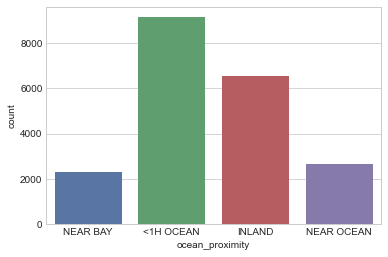

In [3]:
# Ocean_proximity feature in detail

print('\nHere we have the different values that \'ocean proximity\' feature can assume,\nalong with their occurrencies:\n')
print(data['ocean_proximity'].value_counts())
print('\n')
_ = sns.countplot(data.ocean_proximity)

In [4]:
# Categorical data handling

print('\nI dropped the rows which \'ocean_proximity\' value is \'ISLAND\', because they are too few!\n')
data_noisland = data[data.ocean_proximity != 'ISLAND']

print('To manage categorical data, two general approaches are possible:')
print('1. LabelEncoder + OneHotEncoder')
print('2. Pandas getDummies')
print('\n')
print('Label encoder alone is not a good choice as long as the categorical values are more than 2.\nIn this case in fact the model would consider a value "greater" than the other,\nthus leading to poor performance\n')
print('I chose pandas get dummies because it\'s easier to understand and outputs a dataframe,\nso it requires little to no effort\n')

dummies = pd.get_dummies(data_noisland.ocean_proximity)
data_noisland[dummies.columns] = dummies

print('I deleted the column \'ocean_proximity\' and put the label we are willing to predict as last\n')
pr_data = data_noisland[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'
       , '<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN','median_house_value']]


I dropped the rows which 'ocean_proximity' value is 'ISLAND', because they are too few!

To manage categorical data, two general approaches are possible:
1. LabelEncoder + OneHotEncoder
2. Pandas getDummies


Label encoder alone is not a good choice as long as the categorical values are more than 2.
In this case in fact the model would consider a value "greater" than the other,
thus leading to poor performance

I chose pandas get dummies because it's easier to understand and outputs a dataframe,
so it requires little to no effort

I deleted the column 'ocean_proximity' and put the label we are willing to predict as last



In [5]:
# Filling nullable values

print('\nAs seen before, the \'total_bedrooms\' feature assumes NULL value sometimes,\nlet\'s see it more in detail\n')
print(pr_data.isna().sum())

print('\n')

print('%d rows are too many to be dropped, so I will fill them with the mean value\n' %pr_data.total_bedrooms.isna().sum())
proc_data = pr_data.fillna(pr_data.mean())

print('Number of null values after \'fillna\': %d\n' %proc_data.total_bedrooms.isna().sum())

print('\n')

print('Let\'s have a look on the data after these modifications\n')
proc_data.head()


As seen before, the 'total_bedrooms' feature assumes NULL value sometimes,
let's see it more in detail

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
<1H OCEAN               0
INLAND                  0
NEAR BAY                0
NEAR OCEAN              0
median_house_value      0
dtype: int64


207 rows are too many to be dropped, so I will fill them with the mean value

Number of null values after 'fillna': 0



Let's have a look on the data after these modifications



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,0,0,1,0,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,0,0,1,0,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,0,0,1,0,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,0,0,1,0,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,0,0,1,0,342200



First of all I am going to show general correlations between features

Let's say that a positive correlation starts from 0.5 to 0.7 and a strong/perfect correlation
approaches 0.9/1.0, same applies for negative correlation with negative values



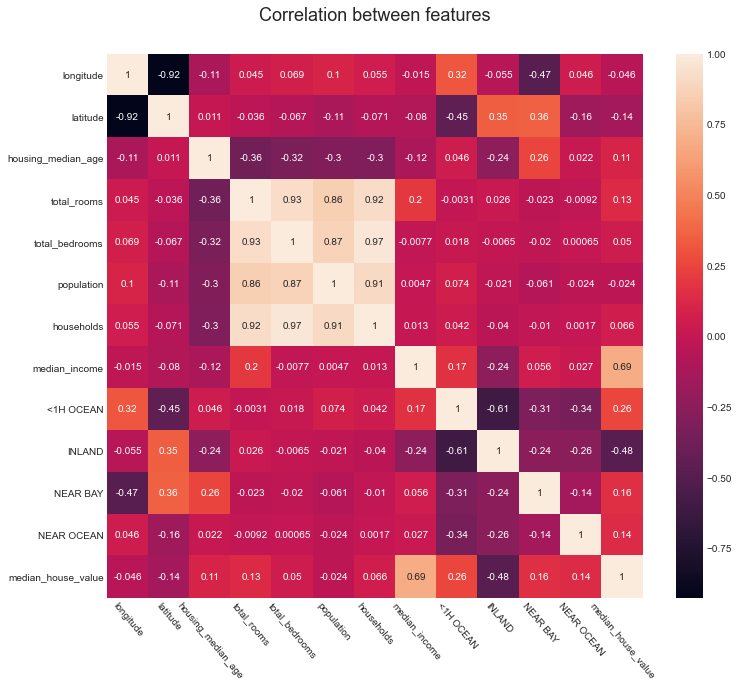

In [6]:
# Correlation between features
print('\nFirst of all I am going to show general correlations between features\n')
print('Let\'s say that a positive correlation starts from 0.5 to 0.7 and a strong/perfect correlation\napproaches 0.9/1.0, same applies for negative correlation with negative values\n')
plt.figure(figsize=(12,10))
plt.title('Correlation between features', fontsize='18').set_position([.5, 1.05])
_ = sns.heatmap(proc_data.corr(), annot=True)
_ = plt.xticks(rotation=-50)

In [9]:
print('\nAs shown in the Heatmap there is a strong correlation between the following features:\n')
print('- households')
print('- total_bedrooms')
print('- total_rooms')
print('- population')

print('\n')

print('This makes sense to me, the number of bedrooms in a district is obviously correlated\nwith the number of rooms in the district, the same is true for the number of families\nand the total population living in a district, finally number  of rooms is correlated\nwith the people\n')

print('In the following dendrogram is spotted also the obvious correlation\nbetween longitude and the nearness to the ocean\n')
print('Reader attention will finally be drawn by the relationship between\nmedian house value and median income, which is high enough and we are going to inspect\n')
corr = 1 - proc_data.corr() 

corr_condensed = hc.distance.squareform(corr)
z = hc.linkage(corr_condensed, method='average')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
data_ = hc.dendrogram(z, ax = ax, labels=corr.columns, orientation="right")


As shown in the Heatmap there is a strong correlation between the following features:

- households
- total_bedrooms
- total_rooms
- population


This makes sense to me, the number of bedrooms in a district is obviously correlated
with the number of rooms in the district, the same is true for the number of families
and the total population living in a district, finally number  of rooms is correlated
with the people

In the following dendrogram is spotted also the obvious correlation
between longitude and the nearness to the ocean

Reader attention will finally be drawn by the relationship between
median house value and median income, which is high enough and we are going to inspect



ValueError: The truth value of a Index is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [10]:
print('\nHere are listed features correlation with median_house_value (sorted by correlation)\n')
proc_data.corr().sort_values(ascending=False, by = 'median_house_value').median_house_value


Here are listed features correlation with median_house_value (sorted by correlation)



median_house_value    1.000000
median_income         0.688563
<1H OCEAN             0.257049
NEAR BAY              0.160467
NEAR OCEAN            0.142051
total_rooms           0.134373
housing_median_age    0.105272
households            0.066069
total_bedrooms        0.049559
population           -0.024421
longitude            -0.046208
latitude             -0.143837
INLAND               -0.484794
Name: median_house_value, dtype: float64


Evidence shows a correlation between the target feature and the 'median_income'
In the next graphs we see more in detail the relationship between these two features



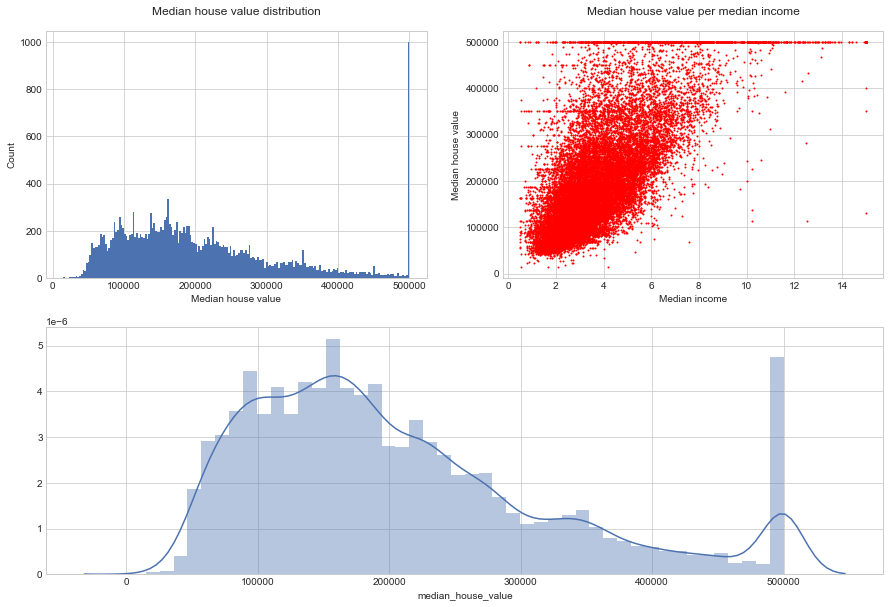

In [11]:
# Correlation between median_house_value and median_income

print('\nEvidence shows a correlation between the target feature and the \'median_income\'');
print('In the next graphs we see more in detail the relationship between these two features\n')

fig = plt.figure(figsize=(15, 10))

gs = gridspec.GridSpec(2, 2, figure=fig)

ax = plt.subplot(gs[0, 0]) 
ax.set_title('Median house value distribution').set_position([.5, 1.04])
ax.set(xlabel='Median house value', ylabel='Count')
_ = ax.hist(proc_data.median_house_value,bins=200)

ax = plt.subplot(gs[0, 1]) 
ax.set_title('Median house value per median income').set_position([.5, 1.04])
ax.set(xlabel='Median income', ylabel='Median house value')
_ = ax.plot(proc_data.median_income, proc_data.median_house_value, 'ro', ms=1)

ax = plt.subplot(gs[1, :]) 
ax = sns.distplot(proc_data.median_house_value) #distribution of values

In [12]:
# Features/Target splitting of the dataset

data_x = proc_data.drop(['median_house_value'], axis=1)
data_y = proc_data['median_house_value']



Principal Component Analysis (PCA) aims to convert a set of possibly correlated features
into linearly uncorrelated values, called principal components. This transformation is defined
such that the first component has highest variance, and each succeding component has
highest variance  possible, under the constraint that is orthogonal to the preceding ones


Three main approaches are possible to compute the Principal Components:

-Algorithm 1 (Sequential): Select the component that maximizes the
average sum of squares of that component.
 For each successive component, the PCA reconstructions relative to previous PCs
are subtracted

-Algorithm 2 (Sample Covariance Matrix): Computes the covariance matrix as follow:
(1/m)*Σ(xi - x̄)(xi - x̄)T
 The eigenvectors of the matrix are the PCA basis vectors,
the larger the eigenvalue the more important the PC

-Algorithm 3 (Singular Value Decomposition of centered data matrix X)


In the following graphs are exposed the Individual Explained Vari

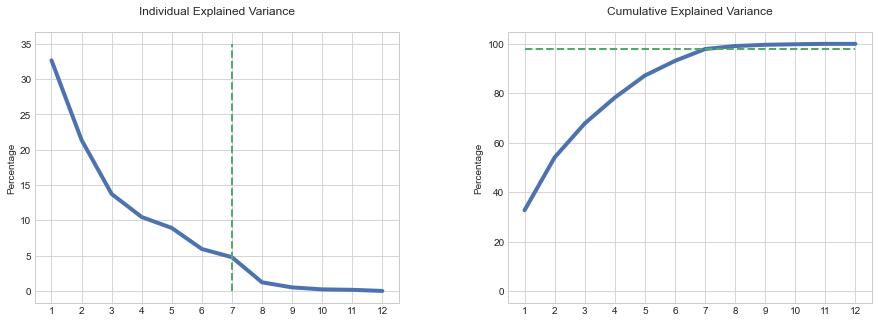

In [13]:
# Principal component analysis

print('\nPrincipal Component Analysis (PCA) aims to convert a set of possibly correlated features\ninto linearly uncorrelated values, called principal components.', \
     'This transformation is defined\nsuch that the first component has highest variance, and each succeding component has\nhighest variance ', \
     'possible, under the constraint that is orthogonal to the preceding ones\n')

print('\nThree main approaches are possible to compute the Principal Components:\n');
print('-Algorithm 1 (Sequential): Select the component that maximizes the\naverage sum of squares of that component.')
print(' For each successive component, the PCA reconstructions relative to previous PCs\nare subtracted\n')
print('-Algorithm 2 (Sample Covariance Matrix): Computes the covariance matrix as follow:\n(1/m)*Σ(xi - x̄)(xi - x̄)T')
print(' The eigenvectors of the matrix are the PCA basis vectors,\nthe larger the eigenvalue the more important the PC\n')
print('-Algorithm 3 (Singular Value Decomposition of centered data matrix X)\n')

# Seeking for a relationship between data, better to work on scaled data
# Standard Scaler returns a numpy array

scaled_data_x = (data_x - data_x.mean()) / data_x.std()
pca = PCA(random_state=pRand, n_components=12)
x_pca = pca.fit_transform(scaled_data_x)

totalvar = 0
for var in pca.explained_variance_:
    totalvar += var

# perc_var is the variance (%) for each feature
perc_var = pca.explained_variance_/totalvar*100


# here i build the cumulative var

cum_var = []

for i in range(0,len(perc_var)):
    cum_var.append(perc_var[i])

for i in range(0,len(perc_var)):
    for j in range(0,i):
        cum_var[i] = cum_var[i] + perc_var[j]
    
print('\nIn the following graphs are exposed the Individual Explained Variance and\nthe Cumulative Explained Variance for the  features, to make easier the job of choosing\nthe number of Principal Components we want to keep\n')

fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].set_xticks(range(1,len(perc_var)+1))
axs[1].set_xticks(range(1,len(cum_var)+1))
#axs[0].set_ylim(ymin=-5,ymax=105)
axs[1].set_ylim(ymin=-5,ymax=105)
axs[0].set_title('Individual Explained Variance').set_position([.5, 1.04])
axs[0].set(xlabel='', ylabel='Percentage')
axs[1].set_title('Cumulative Explained Variance').set_position([.5, 1.04])
axs[1].set(xlabel='', ylabel='Percentage')
plt.subplots_adjust(wspace = 0.3)

_ = axs[0].plot(range(1,len(perc_var)+1),perc_var,linewidth=4)
_ = axs[0].plot([7,7],[0,35],'--',linewidth=2)
_ = axs[1].plot(range(1,len(cum_var)+1),cum_var,linewidth=4)
_ = axs[1].plot([1,12],[97.9,97.9],'--',linewidth=2)

print('5 Components: %d%% of variance\n'%cum_var[4])
print('6 Components: %d%% of variance\n'%cum_var[5])
print('7 Components: %d%% of variance\n'%cum_var[6]) # %f mostra 97.89 ~ 97.9
print('8 Components: %d%% of variance\n'%cum_var[7])

In [14]:
print('\n7 components are enough to explain 97% of the total variance\n')
n_components = 7

pca = PCA(n_components)

pcs = pd.DataFrame(pca.fit_transform(scaled_data_x)) #principal components




7 components are enough to explain 97% of the total variance



In [ ]:
# Comparison between PCs and entire DataSet

#Split datasets with proportion 4:1 for train and test

x_train, x_test, y_train, y_test = train_test_split(scaled_data_x, data_y, test_size=0.2, random_state=pRand)
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(pcs, data_y, test_size=0.2, random_state=pRand)

print('\nIn order to compare the original dataset after pre-processing,\nwith the Principal Components dataset, ', \
      'I am going to evaluate R² score\nusing Cross Validation with K-Folds (K=10)\n')

print('R² (R-Squared) indicates the proportion of variation in the outcome\nthat is explained by the predictor variables\n')

print('R² ≡ 1 - RSS/TSS\nTSS (Total Sum of Squares) = Σ(yi-ȳ)²\nRSS (Residual Sum of Squares) = Σ(yi-fi)²\n')


def test_model(clf,train,labels):
        
        cv = KFold(n_splits=10,shuffle=True,random_state=pRand)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, labels, cv=cv,scoring=r2)
        return [r2_val_score.mean()]



print('Starting with the original dataset:\n')

res = {}

now = time.time()

res['Linear'] = test_model(linear_model.LinearRegression(),x_train,y_train)
res['Decision Tree'] = test_model(DecisionTreeRegressor(),x_train,y_train)
res['Random Forest'] = test_model(RandomForestRegressor(),x_train,y_train)

t = time.time()-now
print('Time: %.3f s\n' %t)

results = pd.DataFrame.from_dict(res,orient='index')
results.columns=["R Square Score"]
results = results.sort_values(by="R Square Score", ascending=False)
fig, axs = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={'width_ratios': [5, 2]})

results.plot(kind="bar",title="Model Scores",ax=axs[0])
axs[0].set_ylim(ymin=0,ymax=1)

plt.subplots_adjust(wspace = 0.4)

bbox=[0, 0, 1, 1]
axs[1].axis('off')
mpl_table = axs[1].table(cellText = results.values, rowLabels = results.index, bbox=bbox, colLabels=results.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(12)

In [ ]:
print('\nProceeding with PCA-Reduced dataset\n')

res = {}

now = time.time()

res['Linear'] = test_model(linear_model.LinearRegression(),x_train_pca,y_train_pca)
res['Decision Tree'] = test_model(DecisionTreeRegressor(),x_train_pca,y_train_pca)
res['Random Forest'] = test_model(RandomForestRegressor(),x_train_pca,y_train_pca)

t = time.time()-now
print('Time: %.2f s\n' %t)

results = pd.DataFrame.from_dict(res,orient='index')
results.columns=["R Square Score"]
results = results.sort_values(by="R Square Score", ascending=False)
fig, axs = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={'width_ratios': [5, 2]})

results.plot(kind="bar",title="Model Scores",ax=axs[0])
axs[0].set_ylim(ymin=0,ymax=1)

plt.subplots_adjust(wspace = 0.4)

bbox=[0, 0, 1, 1]
axs[1].axis('off')
mpl_table = axs[1].table(cellText = results.values, rowLabels = results.index, bbox=bbox, colLabels=results.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(12)


In [17]:
print('\nAltough the PCA-Reduced dataset was faster than the original dataset,\nthe loss in the R-Square score says it all. I am going to proceed using\nthe original preprocessed dataset\n')

print('Let\'s start with the training phase and prediction of the target value\nto check how does the model behave!\n')


Altough the PCA-Reduced dataset was faster than the original dataset,
the loss in the R-Square score says it all. I am going to proceed using
the original preprocessed dataset

Let's start with the training phase and prediction of the target value
to check how does the model behave!



In [18]:
cv = KFold(n_splits=5,shuffle=True,random_state=pRand)


Linear Regression

Linear Regression uses least squares to fit a line to the data
It tries to minimize over w the following sum: Σ(yi - w*xi)² where 'yi' is the target value,
'xi' is the features array and w is the slope

It ends up with an equation looking like this: y = w0 + w1*x + ε

Training time: 17.64 ms

Mean Absolute Error: 49377

R²: 0.642642




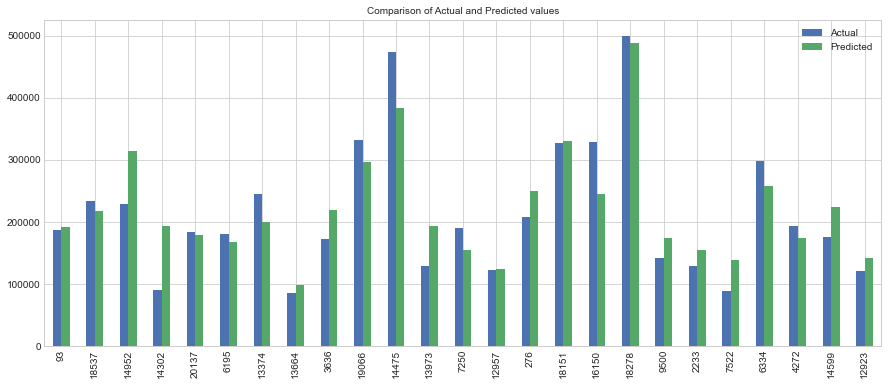

In [19]:
#LINEAR REGRESSION

print('\nLinear Regression\n')

print('Linear Regression uses least squares to fit a line to the data')
print('It tries to minimize over w the following sum: Σ(yi - w*xi)² where \'yi\' is the target value,\n\'xi\' is the features array', \
      'and w is the slope\n')
print('It ends up with an equation looking like this: y = w0 + w1*x + ε\n')


now = time.time()
LRModel = LinearRegression().fit(x_train, y_train)
t = time.time()-now

y_pred = LRModel.predict(x_test)

res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})

print('Training time: %.2f ms\n' %(t*1000))
print('Mean Absolute Error: %d\n' %metrics.mean_absolute_error(y_test, y_pred))  
#print('Mean Squared Error: %d' %metrics.mean_squared_error(y_test, y_pred))  
LRScore = LRModel.score(x_train,y_train)
print('R²: %f' %LRScore)
print('\n')
#res.head(10)
df1 = res.head(25)
df1.plot(kind='bar',figsize=(15,6))
plt.title('Comparison of Actual and Predicted values', fontsize=10)
plt.show()

In [20]:
# print('\nDecision Tree Regression\n')

# print('Decision Trees can be used for regression scope. The tree looks for a best split\nto use as a root node and predicts', \
#      'a new data point as the average of data points\nbelonging to the cluster of the leaf it belongs.\nSplitting too much could', \
#      'of course lead to a low bias and high variance.\nTo prevent overfitting it can decide to split a node only if a cluster\ncontains', \
#      'at least a number of data points greater than a threashold.\nAlso we can set the maximum depth of the tree.\n')
# print('This last parameter is going to be found using a grid search\n')

# depths = range(1,31)
# criterions = ['mse','mae']

# bestMAE = np.inf #set infinite as starting value
# bestDepth = 0
# bestCriterion = ''
# maeR2Scores = []
# mseR2Scores = []
# maeMAEs = []
# mseMAEs = []

# for criterion in criterions:
    
#     for depth in depths:
        
#         DTregressor = DecisionTreeRegressor(random_state = pRand, max_depth=depth, criterion=criterion)
#         _ = DTregressor.fit(x_train, y_train)
#         y_pred = DTregressor.predict(x_test)
        
#         if(criterion == 'mae'):
#             maeR2Scores.append(DTregressor.score(x_train,y_train))
#             maeMAEs.append(metrics.mean_absolute_error(y_test,y_pred))
            
#         if(criterion == 'mse'):
#             mseR2Scores.append(DTregressor.score(x_train,y_train))
#             mseMAEs.append(metrics.mean_absolute_error(y_test,y_pred))
            
#         if(metrics.mean_absolute_error(y_test,y_pred)<bestMAE):
#             bestMAE = metrics.mean_absolute_error(y_test,y_pred)
#             bestDepth = depth
#             bestCriterion = criterion



Decision Tree Regression

Decision Trees can be used for regression scope. The tree looks for a best split
to use as a root node and predicts a new data point as the average of data points
belonging to the cluster of the leaf it belongs.
Splitting too much could of course lead to a low bias and high variance.
To prevent overfitting it can decide to split a node only if a cluster
contains at least a number of data points greater than a threashold.
Also we can set the maximum depth of the tree.

This last parameter is going to be found using a grid search



KeyboardInterrupt: 

In [29]:
# print('\nBest parameters for classifier:\n')
# print('- Criterion: %s' %bestCriterion)
# print('- Max depth: %s' %bestDepth)
# print('- Mean Absolute Error of classifier with best parameters: %d\n' %bestMAE)

# print('\nNow let\'s have a look on the behavior of the R-Squared score with respect to the MAE\n')

# print('In the following graph I analyze the trend of the R-Squared score and MAE for\ndifferent depths using the criterion that performed better (%s)\n' %bestCriterion)

# R2Scores = []
# MAEs = []

# if(bestCriterion=='mae'):
#     R2Scores = maeR2Scores
#     MAEs = maeMAEs
# else:
#     R2Scores = mseR2Scores
#     MAEs = mseMAEs


# fig, ax = plt.subplots(1, 1, figsize=(10,6))
    
# _ = ax.plot(range(1,31),R2Scores,linewidth=3, label='R-Squared score')
# _ = ax.plot(range(1,31),MAEs/np.amax(MAEs),linewidth=3, label='Normalized MAE')
# _ = ax.legend(fontsize='medium')
# plt.show()

# print('\nNote that the MAE curve is normalized between 0 and 1, where 1 is the highest MAE occurred\nin the gridsearch; in this way we can spot the overfitting of the model at increasing tree\ndepth, which leads to a very high R2-score but also to a worse performance on the test set\n')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


Best parameters for classifier:

- Criterion: mae
- Max depth: 13
- Mean Absolute Error of classifier with best parameters: 32517


Now let's have a look on the behavior of the R-Squared score with respect to the MAE

In the following graph I analyze the trend of the R-Squared score and MAE for
different depths using the criterion that performed better (mae)

Traceback (most recent call last):
  File "/anaconda3/envs/PythonData/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-431d8117fb02>", line 23, in <module>
    _ = ax.plot(range(1,31),R2Scores,linewidth=3, label='R-Squared score')
  File "/anaconda3/envs/PythonData/lib/python3.6/site-packages/matplotlib/axes/_axes.py", line 1647, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/anacon

TypeError: object of type 'NoneType' has no len()


Decision Tree feature importance



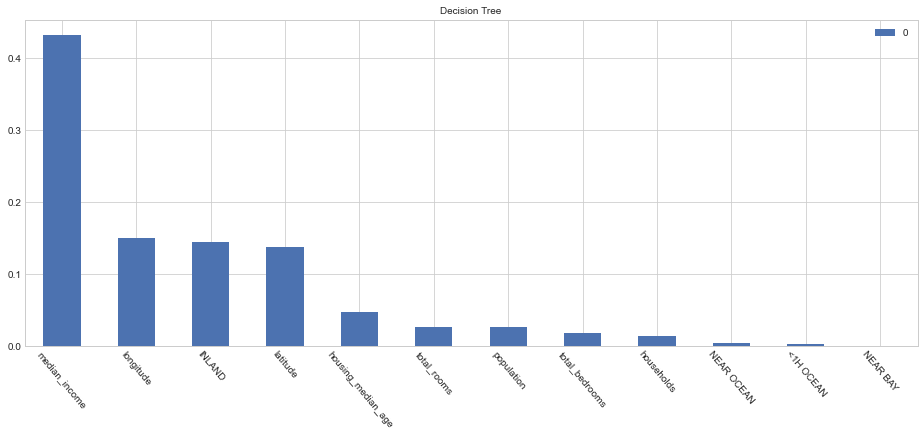

In [32]:
print('\nDecision Tree feature importance\n')

DTregressor = DecisionTreeRegressor(random_state = pRand, max_depth=bestDepth, criterion=bestCriterion)
_ = DTregressor.fit(x_train, y_train)

dic = {}
i = 0
for column in x_train.columns:
    dic[column] = DTregressor.feature_importances_[i]
    i += 1

dfp = pd.DataFrame.from_dict(dic, orient='index')
dfp.sort_values(by=0, ascending=False).plot(kind='bar',figsize=(16,6))
plt.title('Decision Tree', fontsize=10)
plt.xticks(rotation=-50)
plt.show()

In [34]:
print('\nRandom Forest Regression\n')

print('Random Forests are built creating each time a tree, using just a subset of the available\nvariables. In this way we will end up', \
     'with a great variety of trees that will all be used\nto predict target value for new data points; in fact a new point will', \
     'go through each\ntree of the forest and get as predicted value the average of the values predicted by each tree\n')

print('The number of trees for the forest may increase a lot the training time:\nI am going to find the best number of trees in a small subset of values\n')


n_estimators = [10,50,100]


bestMAE = np.inf #set infinite as starting value
bestN_estimators = 0 #number of trees
R2Scores = []
MAEs = []

for n_estimator in n_estimators:
            
    RFregressor = RandomForestRegressor(random_state = pRand, max_depth=bestDepth, criterion=bestCriterion, n_estimators=n_estimator)
    _ = RFregressor.fit(x_train, y_train)
    y_pred = RFregressor.predict(x_test)
        
    R2Scores.append(RFregressor.score(x_train,y_train))
    MAEs.append(metrics.mean_absolute_error(y_test,y_pred))
            
    if(metrics.mean_absolute_error(y_test,y_pred)<bestMAE):
        bestMAE = metrics.mean_absolute_error(y_test,y_pred)
        bestN_estimators = n_estimator
           
        


Random Forest Regression

Random Forests are built creating each time a tree, using just a subset of the available
variables. In this way we will end up with a great variety of trees that will all be used
to predict target value for new data points; in fact a new point will go through each
tree of the forest and get as predicted value the average of the values predicted by each tree

The number of trees for the forest may increase a lot the training time:
I am going to find the best number of trees in a small subset of values



KeyboardInterrupt: 

In [ ]:
print('\nBest parameters for classifier:\n')
print('- Criterion: %s' %bestCriterion)
print('- Max depth: %s' %bestDepth)
print('- Best number of estimators: %s' %bestN_estimators)
print('- Mean Absolute Error of classifier with best parameters: %d\n' %bestMAE)

print('\nAs shown below, there\'s a little improvement in the Mean Absolute Error\nfor increasing number of estimators:\n')

for i in range(3):
    print('%d estimators - MAE: ' %n_estimators[i] + '%d' %MAEs[i])

print('\n')

RFregressor = RandomForestRegressor(random_state = pRand, max_depth=bestDepth, criterion=bestCriterion, n_estimators=bestN_estimators)
_ = RFregressor.fit(x_train, y_train)
y_pred = RFregressor.predict(x_test)

res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
df1 = res.head(25)
df1.plot(kind='bar',figsize=(15,6))
plt.title('Comparison of Actual and Predicted values', fontsize=10)
plt.show()

In [ ]:
print('\nRandom Forest feature importance\n')

dic = {}
i = 0
for column in x_train.columns:
    dic[column] = RFregressor.feature_importances_[i]
    i += 1

dfp = pd.DataFrame.from_dict(dic, orient='index')
dfp.sort_values(by=0, ascending=False).plot(kind='bar',figsize=(16,6))
plt.title('Importance of the features in the Random Forest', fontsize=10)
plt.xticks(rotation=-50)
plt.show()

In [ ]:
print('\nConclusions\n')

print('Models that perfomed the best were Support Vector Regressor and Random Forest.\nDecision Tree and Random Forest results', \
     'are easily interpretable thanks to the\nfeature importance. They relied on very similar features for the decision making\n')

print('As also seen in the start of this study, \'median_income\' had a key role\nin the prediction of the median house value in a district', \
     'and this makes a lot of\nsense, because in many places rich people live in different districts with respect\nto poorer people, and of course', \
     'in more expensive houses\n')

print('Secondly, the geographical position of the district was an important\nfactor in the equation. In fact the latitude and longitude,', \
     'directly\nlinked to the position with respect to the ocean gave a good hint to understand\nhow much a house can cost in a certain district\n\n')